In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE 
import shap

# Dataset Understanding and Data Cleaning

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
# Checking for all column names
print(df.columns)
# Checking for variable types
print(df.dtypes)

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')
ID                              int64
LIMIT_BAL                     float64
SEX                             int64
EDUCATION                       int64
MARRIAGE                        int64
AGE                             int64
PAY_0                           int64
PAY_2                           int64
PAY_3                           int64
PAY_4                           int64
PAY_5                           int64
PAY_6                           int64
BILL_AMT1                     float64
BILL_AMT2                     float64
BILL_AMT3                     float64
BILL_AMT4                     float64
BILL_AMT5                     float64
BILL

In [4]:
# The default payment next month is the target variable (will the person default or not)
df["default.payment.next.month"].value_counts()

default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64

In [5]:
# Rename columns for clarity
df.rename(columns={
    "PAY_0": "PAY_SEP",
    "PAY_2": "PAY_AUG",
    "PAY_3": "PAY_JUL",
    "PAY_4": "PAY_JUN",
    "PAY_5": "PAY_MAY",
    "PAY_6": "PAY_APR",
    "default.payment.next.month": "default_next_month"
}, inplace = True)

In [6]:
# Mapping categorical codes to labels

# Gender

df["SEX"] = df["SEX"].replace({1: "Male", 2: "Female"})
# Education
df["EDUCATION"] = df["EDUCATION"].replace({
    1: "Graduate School",
    2: "University",
    3: "High School",
    4: "Other",
    5: "Unknown",
    6: "Unknown",
})

# Marriage
df["MARRIAGE"] = df["MARRIAGE"].replace({
    1: "Married",
    2: "Single",
    3: "Other",
    0: "Unknown"
})

# Repayment status (-1 = paid in full, 0 = no delay, 1–9 = months delayed)
pay_status_map = {-1: "Paid in Full", 0: "No Delay"}
df["PAY_SEP"] = df["PAY_SEP"].replace(pay_status_map)
df["PAY_AUG"] = df["PAY_AUG"].replace(pay_status_map)
df["PAY_JUL"] = df["PAY_JUL"].replace(pay_status_map)
df["PAY_JUN"] = df["PAY_JUN"].replace(pay_status_map)
df["PAY_MAY"] = df["PAY_MAY"].replace(pay_status_map)
df["PAY_APR"] = df["PAY_APR"].replace(pay_status_map)

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_next_month
0,1,20000.0,Female,University,Married,24,2,2,Paid in Full,Paid in Full,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,Female,University,Single,26,Paid in Full,2,No Delay,No Delay,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,Female,University,Single,34,No Delay,No Delay,No Delay,No Delay,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,Female,University,Married,37,No Delay,No Delay,No Delay,No Delay,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,Male,University,Married,57,Paid in Full,No Delay,Paid in Full,No Delay,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
# Remove duplicates based on ID only (only keeping the first entry by ID)
df = df.drop_duplicates(subset="ID", keep="first")
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_next_month
0,1,20000.0,Female,University,Married,24,2,2,Paid in Full,Paid in Full,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,Female,University,Single,26,Paid in Full,2,No Delay,No Delay,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,Female,University,Single,34,No Delay,No Delay,No Delay,No Delay,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,Female,University,Married,37,No Delay,No Delay,No Delay,No Delay,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,Male,University,Married,57,Paid in Full,No Delay,Paid in Full,No Delay,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,Male,High School,Married,39,No Delay,No Delay,No Delay,No Delay,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,Male,High School,Single,43,Paid in Full,Paid in Full,Paid in Full,Paid in Full,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,Male,University,Single,37,4,3,2,Paid in Full,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,Male,High School,Married,41,1,Paid in Full,No Delay,No Delay,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [8]:
# Check for missing values
print(df.isnull().sum())

ID                    0
LIMIT_BAL             0
SEX                   0
EDUCATION             0
MARRIAGE              0
AGE                   0
PAY_SEP               0
PAY_AUG               0
PAY_JUL               0
PAY_JUN               0
PAY_MAY               0
PAY_APR               0
BILL_AMT1             0
BILL_AMT2             0
BILL_AMT3             0
BILL_AMT4             0
BILL_AMT5             0
BILL_AMT6             0
PAY_AMT1              0
PAY_AMT2              0
PAY_AMT3              0
PAY_AMT4              0
PAY_AMT5              0
PAY_AMT6              0
default_next_month    0
dtype: int64


In [9]:
# Merge 0, Unknown and Other into Others
df["EDUCATION"] = df["EDUCATION"].replace({0: "Others", "Unknown": "Others", "Other": "Others"})
df["EDUCATION"].value_counts()

EDUCATION
University         14030
Graduate School    10585
High School         4917
Others               468
Name: count, dtype: int64

In [10]:
# Merge Other and Unknown into Others
df["MARRIAGE"] = df["MARRIAGE"].replace({"Other": "Others", "Unknown": "Others"})
df["MARRIAGE"].value_counts()

MARRIAGE
Single     15964
Married    13659
Others       377
Name: count, dtype: int64

# Exploratory Data Analysis (EDA)

C:\Users\Mega-PC\AppData\Local\Temp\ipykernel_3280\4048919033.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="default_next_month", data=df, palette="Set2")


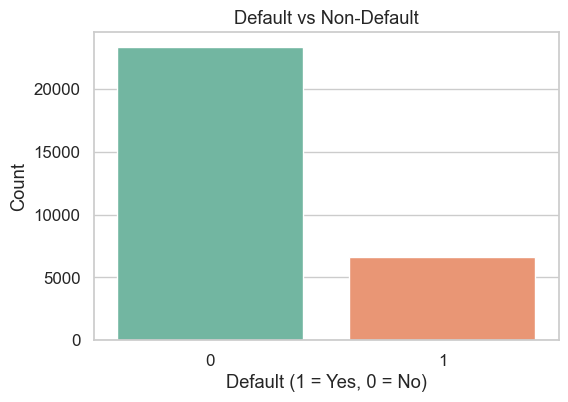

In [11]:
# Setting style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
# Target Variable Balance (default_next_month column)
plt.figure(figsize=(6,4))
sns.countplot(x="default_next_month", data=df, palette="Set2")
plt.title("Default vs Non-Default")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

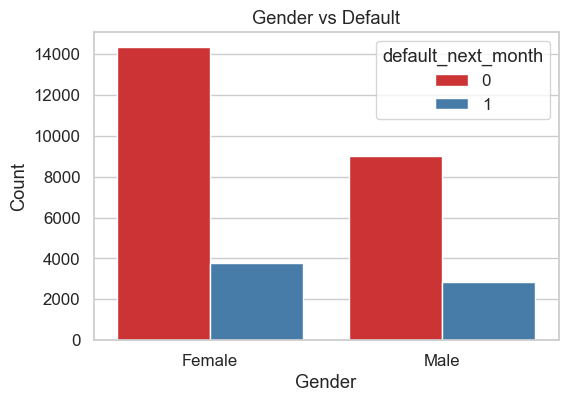

In [12]:
# Gender & Default Rate
plt.figure(figsize=(6,4))
sns.countplot(x="SEX", hue="default_next_month", data=df, palette="Set1")
plt.title("Gender vs Default")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

C:\Users\Mega-PC\AppData\Local\Temp\ipykernel_3280\97436439.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="EDUCATION", data=df, order=df["EDUCATION"].value_counts().index, palette="Paired")


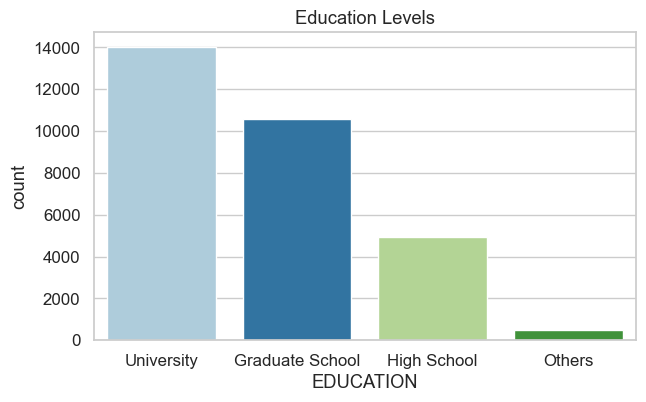

In [13]:
# Education Distribution
plt.figure(figsize=(7,4))
sns.countplot(x="EDUCATION", data=df, order=df["EDUCATION"].value_counts().index, palette="Paired")
plt.title("Education Levels")
plt.show()

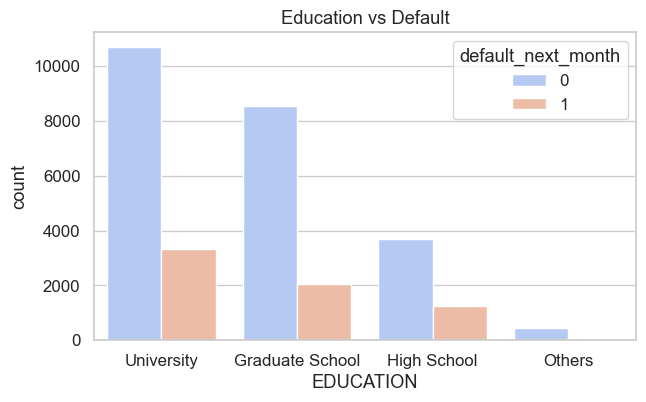

In [14]:
# Education vs Default
plt.figure(figsize=(7,4))
sns.countplot(x="EDUCATION", hue="default_next_month", data=df, palette="coolwarm")
plt.title("Education vs Default")
plt.show()

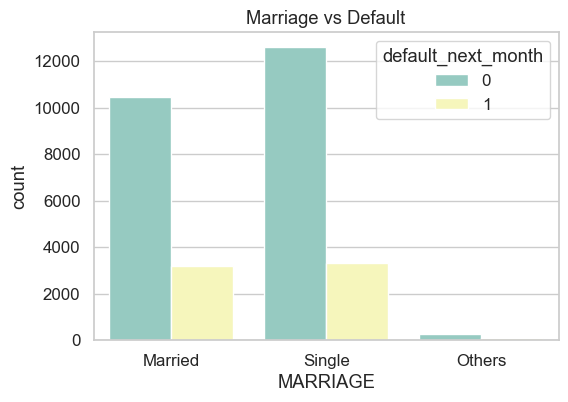

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x="MARRIAGE", hue="default_next_month", data=df, palette="Set3")
plt.title("Marriage vs Default")
plt.show()

C:\Users\Mega-PC\AppData\Local\Temp\ipykernel_3280\3134001177.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="default_next_month", y="AGE", data=df, palette="Set2")


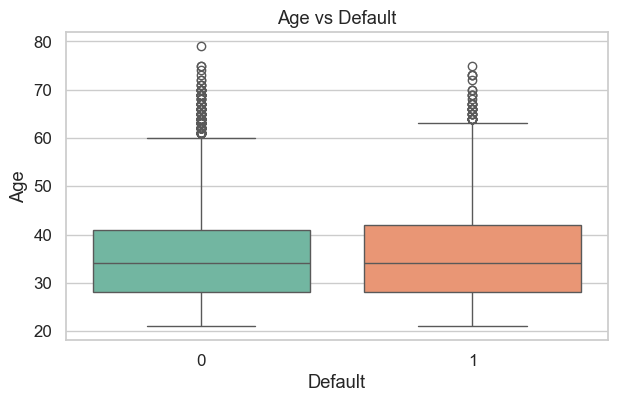

In [16]:
plt.figure(figsize=(7,4))
sns.boxplot(x="default_next_month", y="AGE", data=df, palette="Set2")
plt.title("Age vs Default")
plt.xlabel("Default")
plt.ylabel("Age")
plt.show()

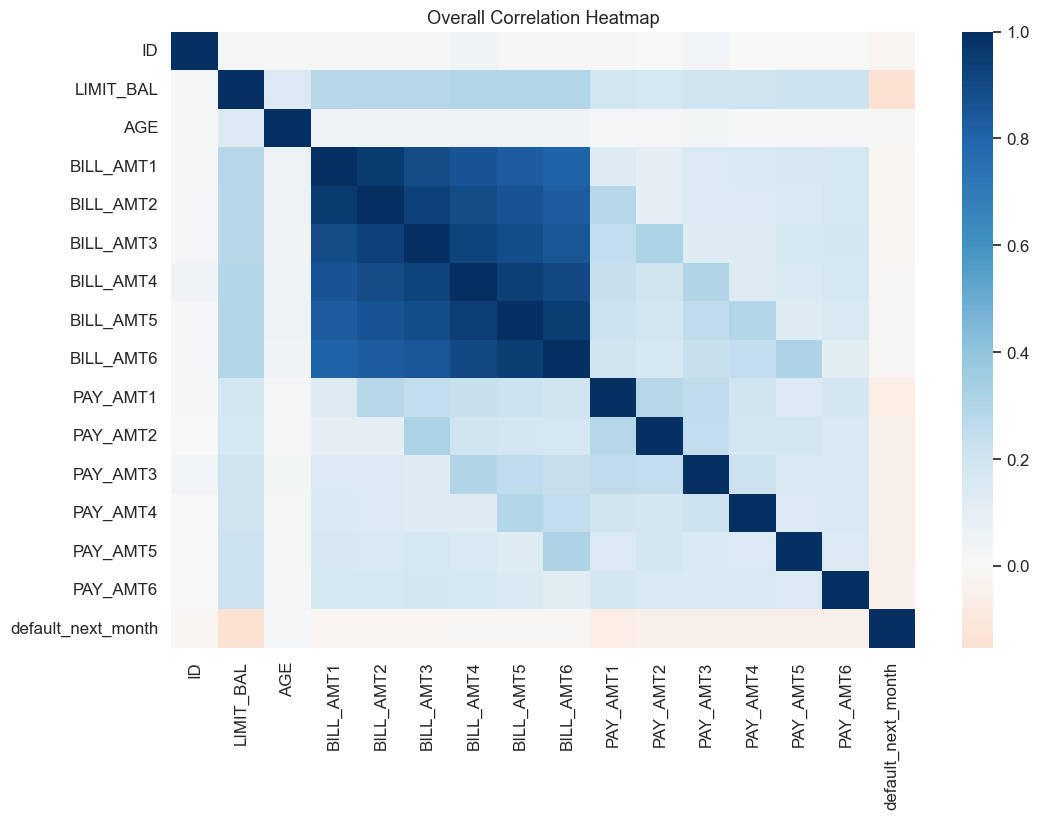

In [17]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap="RdBu", center=0, annot=False)
plt.title("Overall Correlation Heatmap")
plt.show()

# Insights from EDA

From the target variable distribution, most clients do not default which implifies that the dataset is imbalanced 

The dataset shows that there are slightly more female clients than male, but gender alone does not appear to be a strong predictor of default. Most clients hold a university or graduate school education, while those with only high school or other education levels show slightly higher default rates. Marital status is mostly split between married and single clients, with single clients tending to have somewhat higher default rates. In terms of age, the majority of clients fall between 20 and 40 years old, and analysis indicates that younger clients, particularly those in their 20s, are more likely to default compared to older clients, as confirmed by the boxplot where defaulters have a lower median age.

Credit behavior plays a crucial role in predicting default. Credit limits vary widely, from as low as 10,000 to over 1,000,000, with clients holding lower limits showing a higher tendency to default, while those with higher limits generally appear more financially stable and lower risk. Payment history (PAY_0 to PAY_6) emerges as the strongest predictor of default, where negative values indicate early payments, zero reflects on-time payments, and positive values capture delays in months. Defaulters are typically characterized by consistent late payments in recent months.

The correlation analysis further supports these insights. Strong correlations exist among the billing amounts (BILL_AMT1–6) and among the payment amounts (PAY_AMT1–6), while the most recent payment status (PAY_0) shows a particularly strong relationship with default. In contrast, demographic factors such as age, gender, marital status, and education are much weaker predictors compared to payment history, highlighting the dominant influence of credit behavior on default risk.

# Feature engineering

In [18]:
# Repayment Ratio
for i in range(1, 7):
    df[f'REPAY_RATIO{i}'] = df[f'PAY_AMT{i}'] / (df[f'BILL_AMT{i}'] + 1)  # +1 to avoid dividing by zero
# Total Bills and Total Payments
df["TOTAL_BILL"] = df[[f'BILL_AMT{i}' for i in range(1, 7)]].sum(axis=1)
df["TOTAL_PAYMENT"] = df[[f'PAY_AMT{i}' for i in range(1, 6+1)]].sum(axis=1)
df["PAYMENT_RATIO"] = df["TOTAL_PAYMENT"] / (df["TOTAL_BILL"] + 1)
# Payment Consistency (output will be number of months with non-zero payments)
df["PAYMENT_FREQ"] = (df[[f'PAY_AMT{i}' for i in range(1, 7)]] > 0).sum(axis=1)
# Credit Utilization Ratio
df["UTILIZATION"] = df["TOTAL_BILL"] / (df["LIMIT_BAL"] + 1)
# Trend Features
df["BILL_TREND"] = df[["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"]].mean(axis=1) - df["BILL_AMT6"]
df["PAYMENT_TREND"] = df[["PAY_AMT1","PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6"]].mean(axis=1) - df["PAY_AMT6"]
# Replace inf and NaN with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,REPAY_RATIO4,REPAY_RATIO5,REPAY_RATIO6,TOTAL_BILL,TOTAL_PAYMENT,PAYMENT_RATIO,PAYMENT_FREQ,UTILIZATION,BILL_TREND,PAYMENT_TREND
0,1,20000.0,Female,University,Married,24,2,2,Paid in Full,Paid in Full,...,0.000000,0.000000,0.000000,7704.0,689.0,0.089422,1,0.385181,1284.000000,114.833333
1,2,120000.0,Female,University,Single,26,Paid in Full,2,No Delay,No Delay,...,0.305530,0.000000,0.613121,17077.0,5000.0,0.292774,4,0.142307,-414.833333,-1166.666667
2,3,90000.0,Female,University,Single,34,No Delay,No Delay,No Delay,No Delay,...,0.069774,0.066894,0.321543,101653.0,11018.0,0.108387,6,1.129465,1393.166667,-3163.666667
3,4,50000.0,Female,University,Married,37,No Delay,No Delay,No Delay,No Delay,...,0.038849,0.036913,0.033843,231334.0,8388.0,0.036259,6,4.626587,9008.666667,398.000000
4,5,50000.0,Male,University,Married,57,Paid in Full,No Delay,Paid in Full,No Delay,...,0.429779,0.035985,0.035490,109339.0,59049.0,0.540049,6,2.186736,-907.833333,9162.500000


# Predictive Modeling

In [19]:
# Features
feature_cols = [
    "REPAY_RATIO1", "REPAY_RATIO2", "REPAY_RATIO3", 
    "REPAY_RATIO4", "REPAY_RATIO5", "REPAY_RATIO6",
    "TOTAL_BILL", "TOTAL_PAYMENT", "PAYMENT_RATIO", 
    "PAYMENT_FREQ", "UTILIZATION", "BILL_TREND", "PAYMENT_TREND"
]

X = df[feature_cols]
y = df["default_next_month"]

In [20]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
# Scale Continuous Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

In [23]:
# Logistic Regression (Baseline)
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_bal, y_train_bal)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.86      0.61      0.72      4673
           1       0.32      0.65      0.43      1327

    accuracy                           0.62      6000
   macro avg       0.59      0.63      0.57      6000
weighted avg       0.74      0.62      0.65      6000

ROC-AUC: 0.6807857062110723


In [24]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=200)
rf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:,1]))

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      4673
           1       0.43      0.43      0.43      1327

    accuracy                           0.75      6000
   macro avg       0.63      0.63      0.63      6000
weighted avg       0.75      0.75      0.75      6000

ROC-AUC: 0.7021545955529295


In [25]:
# XGBoost
xgb = XGBClassifier(random_state=42, n_estimators=200, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test_scaled)

print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test_scaled)[:,1]))

C:\Users\Mega-PC\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:02:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      4673
           1       0.38      0.44      0.41      1327

    accuracy                           0.72      6000
   macro avg       0.61      0.62      0.61      6000
weighted avg       0.73      0.72      0.73      6000

ROC-AUC: 0.6820329907527265


Among the three models tested, Random Forest was selected as the best model for predicting credit default. While Logistic Regression achieved a higher recall for defaulters, it did so at the cost of very low precision, meaning it flagged too many clients as risky even when they were not. This could lead to unnecessary rejections of good customers. Random Forest, on the other hand, achieved the best overall balance between precision and recall, along with the highest ROC-AUC score (0.70), which measures the model’s ability to distinguish between defaulters and non-defaulters. This makes it a more reliable and stable choice for financial institutions, as it not only detects defaulters but also reduces the risk of misclassifying non-defaulters.

          Feature  Importance
10    UTILIZATION    0.112152
11     BILL_TREND    0.097948
7   TOTAL_PAYMENT    0.095625
6      TOTAL_BILL    0.082880
8   PAYMENT_RATIO    0.082096
12  PAYMENT_TREND    0.074892
9    PAYMENT_FREQ    0.073056
0    REPAY_RATIO1    0.070690
1    REPAY_RATIO2    0.066347
2    REPAY_RATIO3    0.064061
3    REPAY_RATIO4    0.062576
4    REPAY_RATIO5    0.059594
5    REPAY_RATIO6    0.058081


C:\Users\Mega-PC\AppData\Local\Temp\ipykernel_3280\3764349865.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = "Importance", y = "Feature", data = feature_importance_df.head(15), palette = "viridis")


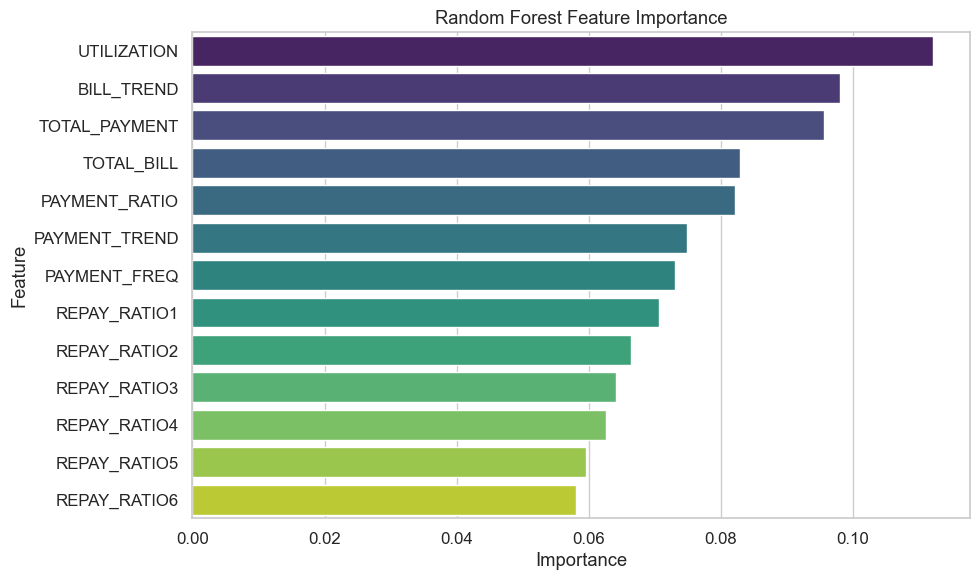

In [26]:
# Get feature importance from the trained Random Forest
importances = rf.feature_importances_

# Put into a DataFrame with feature names
feature_importance_df = pd.DataFrame({
    "Feature": feature_cols,  
    "Importance": importances
})

# Sort by importance descending
feature_importance_df = feature_importance_df.sort_values(by = "Importance", ascending = False)

# Display top features
print(feature_importance_df)

# Plot top 15 features
plt.figure(figsize=(10,6))
sns.barplot(x = "Importance", y = "Feature", data = feature_importance_df.head(15), palette = "viridis")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# Insights

1. Credit Utilization (UTILIZATION) – most important predictor (11.2% importance):

Clients using a higher proportion of their credit limit are more likely to default.

Recommendation: monitor customers with high utilization and consider limiting additional credit or offering financial counseling.

2. Bill Trend (BILL_TREND) – 9.8% importance:

A rising trend in billed amounts indicates growing debt, which correlates with higher default risk.

Recommendation: flag clients whose bills are consistently increasing.

3. Total Payment (TOTAL_PAYMENT) & Total Bill (TOTAL_BILL) – 9.6% & 8.3% importance:

Clients who pay less relative to their total bills are at higher risk.

Recommendation: identify clients with low payment amounts compared to their bills and send reminders or early alerts.

4. Payment Ratio (PAYMENT_RATIO) & Payment Frequency (PAYMENT_FREQ) – 8.2% & 7.3% importance:

Those who pay a small proportion of their bills or pay inconsistently are more likely to default.

Recommendation: design strategies to encourage timely and full payments.

5. Repayment Ratios (REPAY_RATIO1–6) – ~5.8–7% importance each:

Monthly repayment behavior is predictive of future default.

Recommendation: monitor recent months’ repayment patterns closely.

6. Payment Trend (PAYMENT_TREND) – 7.5% importance:

Declining payments over time indicate deteriorating financial behavior.

Recommendation: intervene early if payment trends are downward.

Based on the Random Forest feature importance, several key insights emerge regarding clients’ likelihood to default. Credit utilization is the most important predictor, indicating that clients who use a higher proportion of their available credit are at greater risk of default. Similarly, a rising trend in billed amounts signals growing debt and correlates with higher risk. Both total bill amounts and total payments are important: clients who pay less relative to their total bills are more likely to default, especially if their payments are inconsistent, as reflected in payment ratios and payment frequency. The monthly repayment ratios further highlight that recent repayment behavior is predictive of future defaults, while a declining payment trend indicates deteriorating financial health. Overall, these findings show that behavioral signals, such as utilization, bill trends, and repayment patterns, are much stronger predictors of default than demographics like age, gender, or marital status. Proactively monitoring these factors can help identify high-risk customers early, enabling targeted interventions such as payment reminders, financial counseling, or credit limit adjustments.

# Exporting Final Dataset

In [27]:
df.to_csv("credit_risk_final_tableau.csv", index=False)